In [1]:
# Imports needed across sections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate
from IPython.display import display, HTML

In [4]:
commodities_df = pd.read_csv('all_commodities.csv')
stocks_df = pd.read_csv('all_stocks_and_etfs.csv')
stock_descriptions_df = pd.read_csv('stock_descriptions.csv')
weekly_gas_prices_df = pd.read_csv('weekly_gasoline_prices.csv')
weekly_supply_df = pd.read_csv('weekly_gasoline_prices.csv')
monthly_transportation_df = pd.read_csv('monthly_transportation_statistics.csv')
monthly_gas_prices_df = pd.read_csv('monthly_gasoline_makeup_percentages.csv')

In [7]:
weekly_gas_prices_df.head()

,Date,Year,Type,Type_Clean,Unit,Geography,Price
0,"Jan 03, 2000",2000,Regular Conventional Retail Gasoline Prices (...,Regular Conventional Retail Gasoline Prices,Dollars per Gallon,US,1.260
1,"Jan 10, 2000",2000,Regular Conventional Retail Gasoline Prices (...,Regular Conventional Retail Gasoline Prices,Dollars per Gallon,US,1.252
2,"Jan 17, 2000",2000,Regular Conventional Retail Gasoline Prices (...,Regular Conventional Retail Gasoline Prices,Dollars per Gallon,US,1.268
3,"Jan 24, 2000",2000,Regular Conventional Retail Gasoline Prices (...,Regular Conventional Retail Gasoline Prices,Dollars per Gallon,US,1.307
4,"Jan 31, 2000",2000,Regular Conventional Retail Gasoline Prices (...,Regular Conventional Retail Gasoline Prices,Dollars per Gallon,US,1.307


In [9]:
# Weekly gas prices, Monthly transportation df
gas_type_counts = weekly_gas_prices_df['Type'].value_counts()
print(gas_type_counts)

Type
Regular Conventional Retail Gasoline Prices  (Dollars per Gallon)              37560
Regular Reformulated Retail Gasoline Prices  (Dollars per Gallon)              37560
Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)          37560
Midgrade Conventional Retail Gasoline Prices  (Dollars per Gallon)             37560
Midgrade Reformulated Retail Gasoline Prices  (Dollars per Gallon)             37560
Midgrade All Formulations Retail Gasoline Prices  (Dollars per Gallon)         37560
Premium Conventional Retail Gasoline Prices  (Dollars per Gallon)              37560
Premium Reformulated Retail Gasoline Prices  (Dollars per Gallon)              37560
Premium All Formulations Retail Gasoline Prices  (Dollars per Gallon)          37560
All Grades Conventional Retail Gasoline Prices  (Dollars per Gallon)           37560
All Grades Reformulated Retail Gasoline Prices  (Dollars per Gallon)           37560
All Grades All Formulations Retail Gasoline Prices  (Dollars

In [19]:
# Creating a separate DataFrame for Regular Conventional Gasoline Prices
regular_conventional_df = weekly_gas_prices_df[weekly_gas_prices_df['Type_Clean'] == 'Regular Conventional Retail Gasoline Prices']

# Checking for missing values in the dataframes
print("Missing values in weekly_gas_prices_df:")
print(weekly_gas_prices_df.isnull().sum())
print("\nMissing values in regular_conventional_df:")
print(regular_conventional_df.isnull().sum())


Missing values in weekly_gas_prices_df:
Date               0
Year               0
Type               0
Type_Clean         0
Unit               0
Geography          0
Price         174916
dtype: int64

Missing values in regular_conventional_df:
Date              0
Year              0
Type              0
Type_Clean        0
Unit              0
Geography         0
Price         13700
dtype: int64


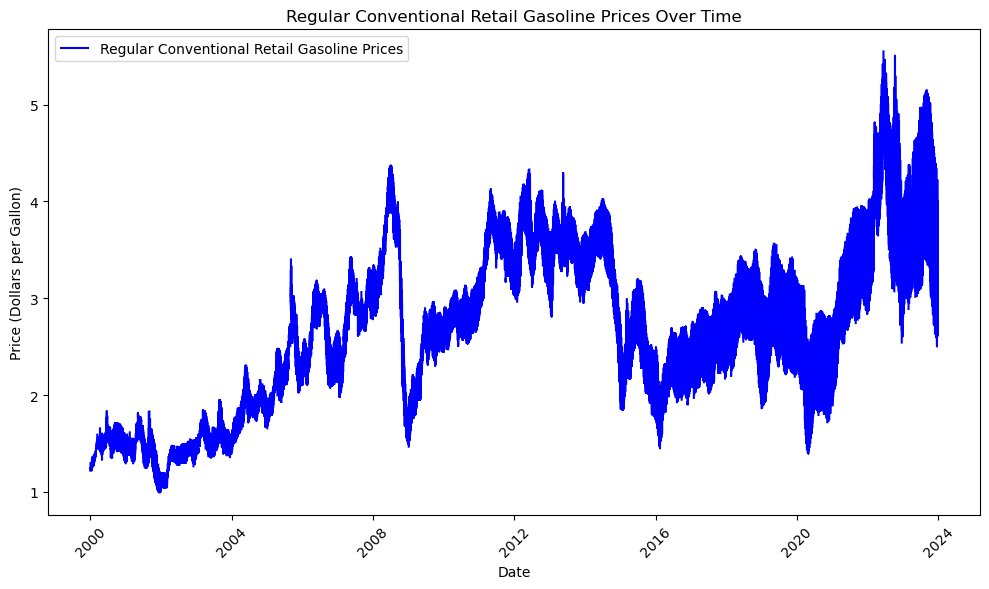

In [22]:
# Convert 'Date' column to datetime format
regular_conventional_df['Date'] = pd.to_datetime(regular_conventional_df['Date'])

# Sort the DataFrame based on the 'Date' column
regular_conventional_df = regular_conventional_df.sort_values('Date')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(regular_conventional_df['Date'], regular_conventional_df['Price'], label='Regular Conventional Retail Gasoline Prices', color='blue')
plt.title('Regular Conventional Retail Gasoline Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (Dollars per Gallon)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
monthly_transportation_df.head()

,Date,Month,Year,Air Safety - General Aviation Fatalities,Highway Fatalities Per 100 Million Vehicle Miles Traveled,Highway Fatalities,U.S. Airline Traffic - Total - Seasonally Adjusted,U.S. Airline Traffic - International - Seasonally Adjusted,U.S. Airline Traffic - Domestic - Seasonally Adjusted,Transit Ridership - Other Transit Modes - Adjusted,...,Heavy truck sales SAAR (millions),U.S. Airline Traffic - Total - Non Seasonally Adjusted,Light truck sales SAAR (millions),U.S. Airline Traffic - International - Non Seasonally Adjusted,Auto sales SAAR (millions),U.S. Airline Traffic - Domestic - Non Seasonally Adjusted,Transborder - Total North American Freight,Transborder - U.S. - Mexico Freight,U.S. marketing air carriers on-time performance (percent),Transborder - U.S. - Canada Freight
0,01/01/2000 12:00:00 AM,1,2000,119.0,NaN,NaN,NaN,NaN,NaN,NaN,...,521000.0,NaN,8808000.0,NaN,9307000.0,NaN,NaN,NaN,NaN,NaN
1,02/01/2000 12:00:00 AM,2,2000,48.0,NaN,NaN,NaN,NaN,NaN,NaN,...,522000.0,NaN,9313000.0,NaN,9566000.0,NaN,NaN,NaN,NaN,NaN
2,03/01/2000 12:00:00 AM,3,2000,38.0,NaN,NaN,NaN,NaN,NaN,NaN,...,521000.0,NaN,8851000.0,NaN,8970000.0,NaN,NaN,NaN,NaN,NaN
3,04/01/2000 12:00:00 AM,4,2000,62.0,NaN,NaN,NaN,NaN,NaN,NaN,...,497000.0,NaN,8539000.0,NaN,8903000.0,NaN,NaN,NaN,NaN,NaN
4,05/01/2000 12:00:00 AM,5,2000,86.0,NaN,NaN,NaN,NaN,NaN,NaN,...,476000.0,NaN,8590000.0,NaN,8877000.0,NaN,NaN,NaN,NaN,NaN


In [24]:
# Check for missing values in monthly_transportation_df
print("Missing values in monthly_transportation_df:")
print(monthly_transportation_df.isnull().sum())

Missing values in monthly_transportation_df:
Date                                                           0
Month                                                          0
Year                                                           0
Air Safety - General Aviation Fatalities                       1
Highway Fatalities Per 100 Million Vehicle Miles Traveled    226
                                                            ... 
U.S. Airline Traffic - Domestic - Non Seasonally Adjusted    221
Transborder - Total North American Freight                    85
Transborder - U.S. - Mexico Freight                           85
U.S. marketing air carriers on-time performance (percent)    219
Transborder - U.S. - Canada Freight                           85
Length: 137, dtype: int64


In [28]:
# Nicely listing all features of the monthly_transportation_df DataFrame
print("Features of monthly_transportation_df:")
for feature in monthly_transportation_df.columns:
    print(f"- {feature}")

Features of monthly_transportation_df:
- Date
- Month
- Year
- Air Safety - General Aviation Fatalities
- Highway Fatalities Per 100 Million Vehicle Miles Traveled
- Highway Fatalities
- U.S. Airline Traffic - Total - Seasonally Adjusted
- U.S. Airline Traffic - International - Seasonally Adjusted
- U.S. Airline Traffic - Domestic - Seasonally Adjusted
- Transit Ridership - Other Transit Modes - Adjusted
- Transit Ridership - Fixed Route Bus - Adjusted
- Transit Ridership - Urban Rail - Adjusted
- Freight Rail Intermodal Units
- Freight Rail Carloads
- Highway Vehicle Miles Traveled - All Systems
- Highway Vehicle Miles Traveled - Total Rural
- Highway Vehicle Miles Traveled - Other Rural
- Highway Vehicle Miles Traveled - Rural Other Arterial
- Highway Vehicle Miles Traveled - Rural Interstate
- State and Local Government Construction Spending - Breakwater/Jetty
- State and Local Government Construction Spending - Dam/Levee
- State and Local Government Construction Spending - Conserva

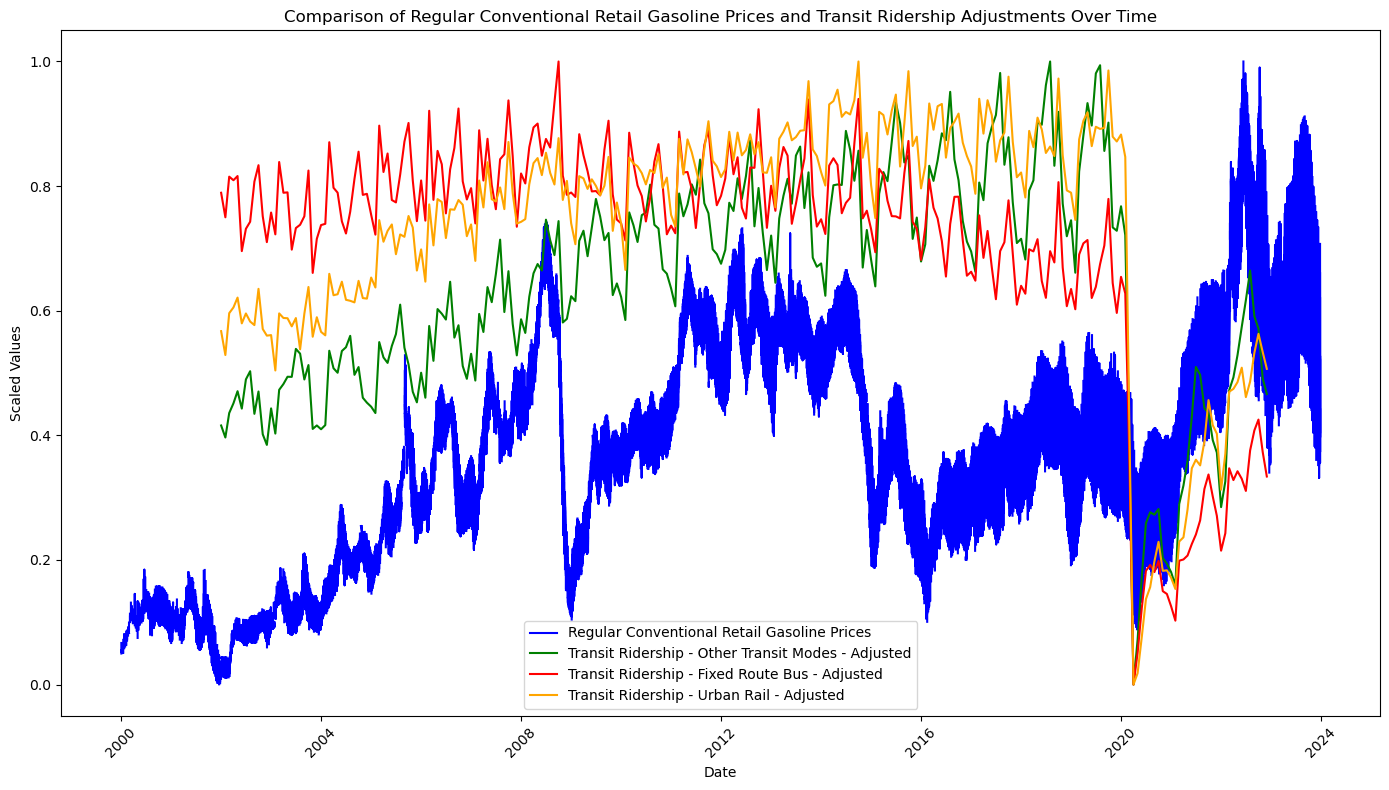

In [27]:
# Convert 'Date' column to datetime format for monthly_transportation_df
monthly_transportation_df['Date'] = pd.to_datetime(monthly_transportation_df['Date'])

# Scaling the features to have the same scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Assuming 'Price' is the only column in regular_conventional_df that needs scaling
regular_conventional_df['Price_Scaled'] = scaler.fit_transform(regular_conventional_df[['Price']])

# Scaling the Transit Ridership data
transit_columns = ['Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted']
monthly_transportation_df[transit_columns] = scaler.fit_transform(monthly_transportation_df[transit_columns])

# Plotting Regular Conventional Retail Gasoline Prices
plt.figure(figsize=(14, 8))
plt.plot(regular_conventional_df['Date'], regular_conventional_df['Price_Scaled'], label='Regular Conventional Retail Gasoline Prices', color='blue')

# Plotting Transit Ridership data
plt.plot(monthly_transportation_df['Date'], monthly_transportation_df['Transit Ridership - Other Transit Modes - Adjusted'], label='Transit Ridership - Other Transit Modes - Adjusted', color='green')
plt.plot(monthly_transportation_df['Date'], monthly_transportation_df['Transit Ridership - Fixed Route Bus - Adjusted'], label='Transit Ridership - Fixed Route Bus - Adjusted', color='red')
plt.plot(monthly_transportation_df['Date'], monthly_transportation_df['Transit Ridership - Urban Rail - Adjusted'], label='Transit Ridership - Urban Rail - Adjusted', color='orange')

plt.title('Comparison of Regular Conventional Retail Gasoline Prices and Transit Ridership Adjustments Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

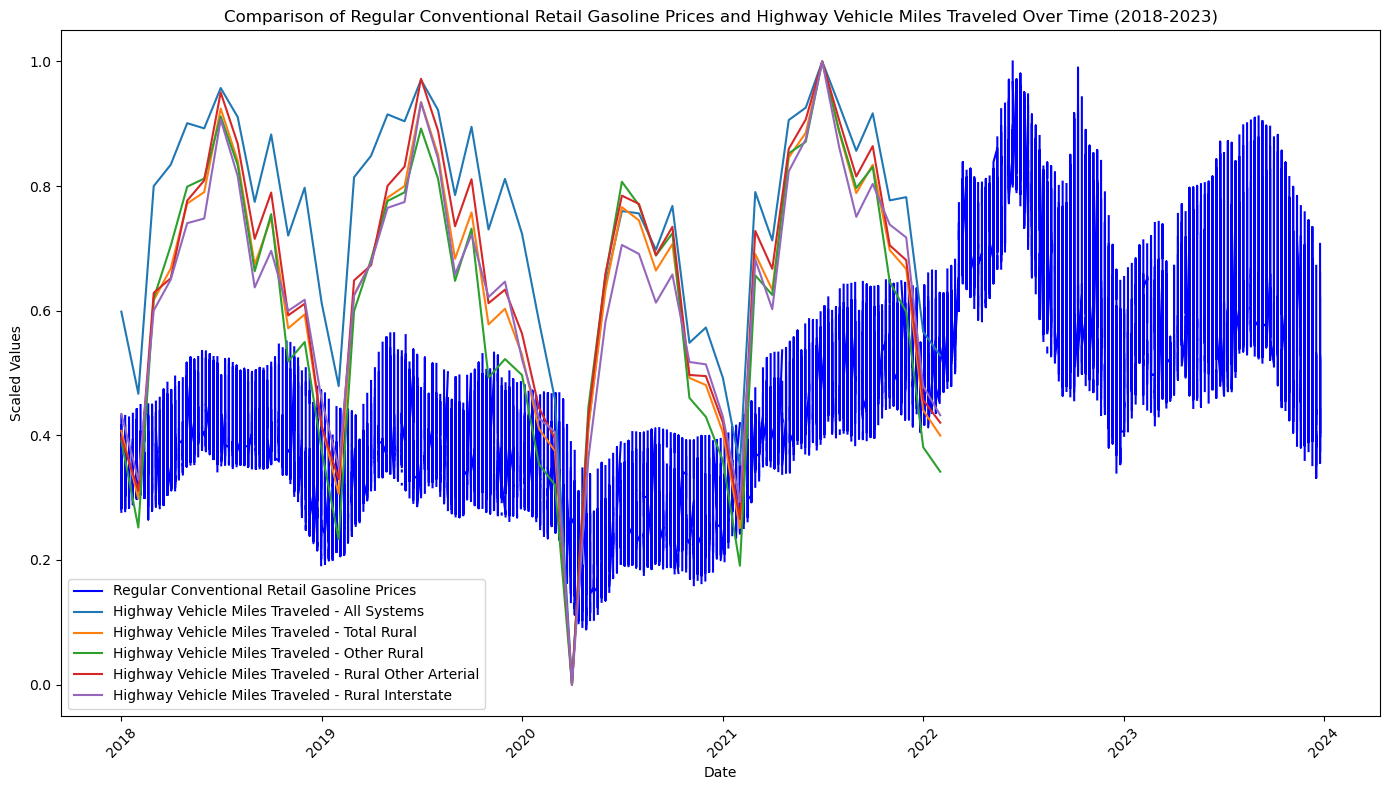

In [30]:
# Scaling and plotting Regular Conventional Prices with all features starting with 'Highway Vehicle Miles Traveled'

# Identifying columns that start with 'Highway Vehicle Miles Traveled'
highway_columns = [col for col in monthly_transportation_df.columns if col.startswith('Highway Vehicle Miles Traveled')]

# Scaling the 'Highway Vehicle Miles Traveled' features
monthly_transportation_df[highway_columns] = scaler.fit_transform(monthly_transportation_df[highway_columns])

# Filtering data for the date range 2018 to 2023
start_date = '2018-01-01'
end_date = '2023-12-31'
filtered_regular_conventional_df = regular_conventional_df[(regular_conventional_df['Date'] >= start_date) & (regular_conventional_df['Date'] <= end_date)]
filtered_monthly_transportation_df = monthly_transportation_df[(monthly_transportation_df['Date'] >= start_date) & (monthly_transportation_df['Date'] <= end_date)]

# Plotting Regular Conventional Retail Gasoline Prices
plt.figure(figsize=(14, 8))
plt.plot(filtered_regular_conventional_df['Date'], filtered_regular_conventional_df['Price_Scaled'], label='Regular Conventional Retail Gasoline Prices', color='blue')

# Plotting 'Highway Vehicle Miles Traveled' features
for col in highway_columns:
    plt.plot(filtered_monthly_transportation_df['Date'], filtered_monthly_transportation_df[col], label=col)

plt.title('Comparison of Regular Conventional Retail Gasoline Prices and Highway Vehicle Miles Traveled Over Time (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

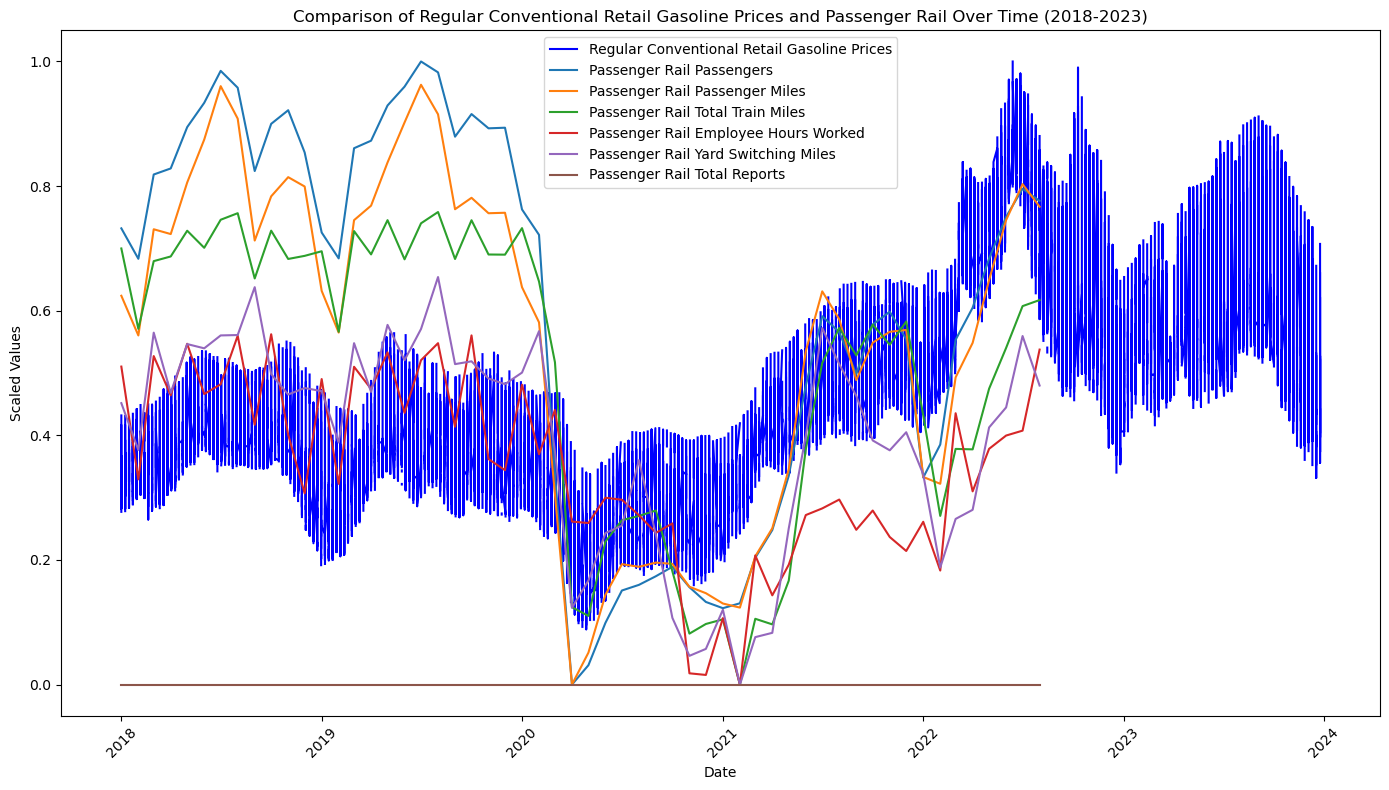

In [31]:
# Identifying columns that contain 'Passenger Rail' data
passenger_rail_columns = [col for col in monthly_transportation_df.columns if 'Passenger Rail' in col]

# Scaling the 'Passenger Rail' features
monthly_transportation_df[passenger_rail_columns] = scaler.fit_transform(monthly_transportation_df[passenger_rail_columns])

# Filtering data for the date range 2018 to 2023 for passenger rail
filtered_monthly_transportation_df_passenger_rail = monthly_transportation_df[(monthly_transportation_df['Date'] >= start_date) & (monthly_transportation_df['Date'] <= end_date)]

# Plotting Regular Conventional Retail Gasoline Prices
plt.figure(figsize=(14, 8))
plt.plot(filtered_regular_conventional_df['Date'], filtered_regular_conventional_df['Price_Scaled'], label='Regular Conventional Retail Gasoline Prices', color='blue')

# Plotting 'Passenger Rail' features
for col in passenger_rail_columns:
    plt.plot(filtered_monthly_transportation_df_passenger_rail['Date'], filtered_monthly_transportation_df_passenger_rail[col], label=col)

plt.title('Comparison of Regular Conventional Retail Gasoline Prices and Passenger Rail Over Time (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
import pandas as pd
import pyreadstat

# Load the .sav file
df, meta = pyreadstat.read_sav('path_to_file.sav')

# Convert the DataFrame to a .csv file
df.to_csv('output_file.csv', index=False)

ModuleNotFoundError: No module named 'pyreadstat'